#### Audio Recognition with Shazam's Algorithm

Initial implementation for graph demostrations (slow query).

Author: Yiming Sun

In [1]:
import os
import time
import librosa
import sqlite3
import numpy as np
from scipy.signal import stft
import matplotlib.pyplot as plt

WIN_SIZE = 4096
HOP_SIZE = WIN_SIZE / 2 # By default in stft()
ANCHOR_DIST = 5
FAN_OUT = 10
FREQ_TH = 1

In [58]:
def fingerprint(x, sr):
    f, t, Zxx = stft(x, sr, nperseg=WIN_SIZE)
    max_f_idx = np.argmax(np.abs(Zxx).T, axis=1)
    
    #
    peaks = []
    for i in max_f_idx:
        p = int(f[i]//10)   
        if p > 1023:
            p = 1023
        peaks += [p]
    
    fps = [] # (anchor's frequency, target point's frequency, time difference in frames)
    for i in range(len(peaks)-ANCHOR_DIST-FAN_OUT):
        anchor_f = peaks[i]
        for j in range(i+ANCHOR_DIST, i+ANCHOR_DIST+FAN_OUT):
            target_f = peaks[j]
            det_t = j - i
            
            hash = (anchor_f<<20) + (target_f<<10) + det_t
            fps += [(i, hash)]

    return fps


def score(fp_song, fp_rec, plot=False):
    idx_song = []
    idx_rec = []
    offsets = []
    
    # Brute force.
    for i in range(len(fp_song)):
        pt1 = fp_song[i]
        for j in range(len(fp_rec)):
            pt2 = fp_rec[j]
            if pt1[2] == pt2[2]: # Time must match exactly.
                if np.abs(pt1[0]-pt2[0]) + np.abs(pt1[1]-pt2[1]) < FREQ_TH:
                    idx_song += [i]
                    idx_rec += [j]
                    offsets += [i-j]

    if plot:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.title("Matched locations")
        plt.xlabel("Database song time (frame)")
        plt.ylabel("Sample time (frame)")
        plt.hist2d(idx_song, idx_rec, (100, 100), cmap=plt.cm.jet)

        plt.subplot(1, 2, 2)
        plt.title("Time Offsets")
        plt.xlabel("Time offset (frame)")
        plt.ylabel("Count")
        plt.hist(offsets, rwidth=0.75)

    # Score is the highest number of occurances in offsets.
    return max(np.histogram(offsets)[0])


def match(conn, fp_rec):
    start = time.time()
    
    scores = {}
    for filename, fp_song in fp_db.items():
        scores[filename] = score(fp_song, fp_rec)
    
    keys_sorted = sorted(scores, key=(lambda key:scores[key]), reverse=True)
    print("Matching result:")
    for i in range(len(keys_sorted)):
        # The top result is 100%.
        score_pct = scores[keys_sorted[i]] / scores[keys_sorted[0]] * 100
        print("{:2d}. {}: {:.2f}% matched (maximum offset count = {})".format(i+1, keys_sorted[i], score_pct, scores[keys_sorted[i]]))
        
    print("Time spent on matching: {:.2f} s".format(time.time()-start))

In [157]:
y, sr_y = librosa.load("rock_rec.wav")
fp_rec = fingerprint(y, sr_y)

match(fp_db, fp_rec)

Matching result:
 1. rock.wav: 100.00% matched (maximum offset count = 127)
 2. The_Hunter.mp3: 1.57% matched (maximum offset count = 2)
 3. Beach_Bum_Happy_Rock.mp3: 0.79% matched (maximum offset count = 1)
 4. For_Mimi.mp3: 0.00% matched (maximum offset count = 0)
 5. Heavy_Hunter.mp3: 0.00% matched (maximum offset count = 0)
 6. Iron_Bacon.mp3: 0.00% matched (maximum offset count = 0)
 7. Cantina_Blues_Take_the_Lead.mp3: 0.00% matched (maximum offset count = 0)
 8. Good_for_Nothing_Safety.mp3: 0.00% matched (maximum offset count = 0)
 9. Delusion_32.mp3: 0.00% matched (maximum offset count = 0)
10. Progressive_Rock.mp3: 0.00% matched (maximum offset count = 0)
Time spent on matching: 22.58 s


In [159]:
y, sr_y = librosa.load("audio/rock.wav")
fp_rec = fingerprint(y[:10*sr_y], sr_y)

match(fp_db, fp_rec)

Matching result:
 1. rock.wav: 100.00% matched (maximum offset count = 1228)
 2. For_Mimi.mp3: 21.99% matched (maximum offset count = 270)
 3. Beach_Bum_Happy_Rock.mp3: 19.22% matched (maximum offset count = 236)
 4. Heavy_Hunter.mp3: 6.35% matched (maximum offset count = 78)
 5. Delusion_32.mp3: 4.80% matched (maximum offset count = 59)
 6. Cantina_Blues_Take_the_Lead.mp3: 1.87% matched (maximum offset count = 23)
 7. The_Hunter.mp3: 1.38% matched (maximum offset count = 17)
 8. Iron_Bacon.mp3: 0.81% matched (maximum offset count = 10)
 9. Good_for_Nothing_Safety.mp3: 0.73% matched (maximum offset count = 9)
10. Progressive_Rock.mp3: 0.49% matched (maximum offset count = 6)
Time spent on matching: 21.36 s


127


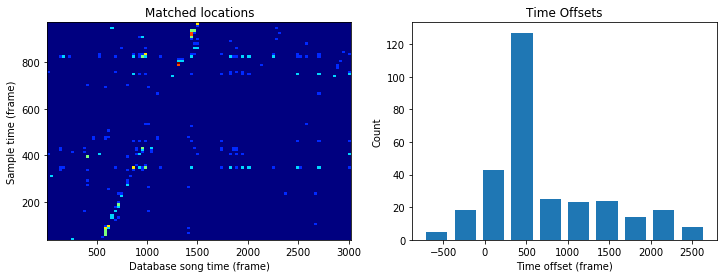

In [94]:
x, sr_x = librosa.load("rock.wav")
y, sr_y = librosa.load("recording.wav")

fp_db = fingerprint(x, sr_x)
fp_rec = fingerprint(y, sr_y)

score(fp_db, fp_rec, plot=True)

1228


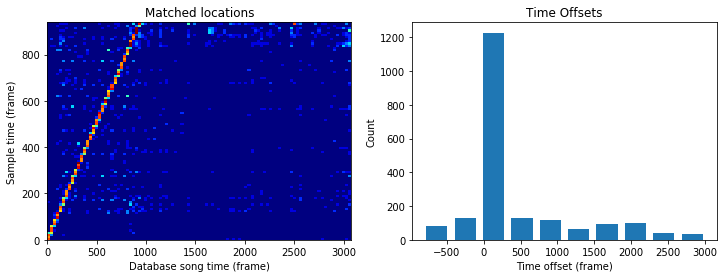

In [95]:
x, sr_x = librosa.load("rock.wav")
y = x[:10*sr_x]

fp_db = fingerprint(x, sr_x)
fp_rec = fingerprint(y, sr_x)

score(fp_db, fp_rec, plot=True)

3


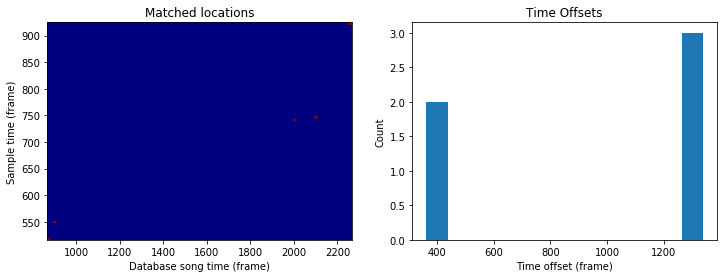

In [96]:
x, sr_x = librosa.load("disco.00001.wav")

fp_db = fingerprint(x, sr_x)
fp_rec = fingerprint(y, sr_y)

score(fp_db, fp_rec, plot=True)

507

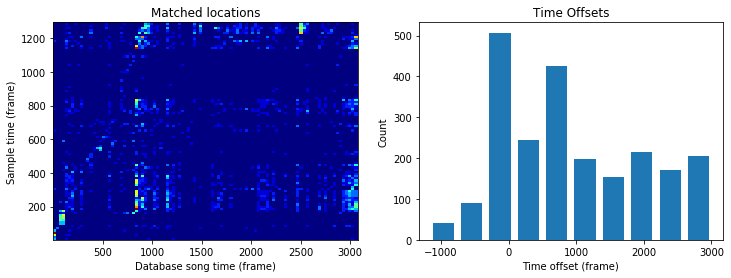

In [174]:
y, sr_y = librosa.load("rock_rec.wav")
y = librosa.effects.time_stretch(x[:10*sr_x], 0.75)

fp_song = fingerprint(x, sr_x)
fp_rec = fingerprint(y, sr_x)

score(fp_song, fp_rec, plot=True)

In [173]:
y, sr_y = librosa.load("rock_rec.wav")
y = librosa.effects.time_stretch(x[:10*sr_x], 0.75)

fp_rec = fingerprint(y, sr_y)
match(fp_db, fp_rec)

Matching result:
 1. rock.wav: 100.00% matched (maximum offset count = 507)
 2. For_Mimi.mp3: 18.74% matched (maximum offset count = 95)
 3. Iron_Bacon.mp3: 12.82% matched (maximum offset count = 65)
 4. Delusion_32.mp3: 12.43% matched (maximum offset count = 63)
 5. Beach_Bum_Happy_Rock.mp3: 11.64% matched (maximum offset count = 59)
 6. Heavy_Hunter.mp3: 7.50% matched (maximum offset count = 38)
 7. The_Hunter.mp3: 2.56% matched (maximum offset count = 13)
 8. Cantina_Blues_Take_the_Lead.mp3: 1.18% matched (maximum offset count = 6)
 9. Good_for_Nothing_Safety.mp3: 0.99% matched (maximum offset count = 5)
10. Progressive_Rock.mp3: 0.99% matched (maximum offset count = 5)
Time spent on matching: 29.87 s
